# Inertial Brownian motion simulation

The Inertial Langevin equation for a particle of mass $m$ and some damping $\gamma$ writes:

\begin{equation}
m\ddot{x} = -\gamma \dot{x} + \sqrt{2k_\mathrm{B}T \gamma} \mathrm{d}B_t
\end{equation}

Integrating the latter equation using the Euler method, one can replace $\dot{x}$ by:

\begin{equation}
\dot{x} \simeq \frac{x_i - x_{i-1}}{\tau} ~,
\end{equation}

$\ddot{x}$ by:

\begin{equation}
	\begin{aligned}
	\ddot{x} &\simeq 
	\frac{
		\frac{x_i - x_{i-1}}{\tau}
		-
		\frac{x_{i-1} - x_{i-2}}{\tau}
	}
	{\tau} \\
	& =  \frac{x_i - 2x_{i - 1} + x_{i-2}}{\tau^2} ~.
	\end{aligned}
\end{equation}

and finally, $\mathrm{d}B_t$ by a Gaussian random number $w_i$ with a zero mean value and a $\tau$ variance, on can write $x_i$ as:

\begin{equation}	
	x_i = \frac{2 + \tau /\tau_\mathrm{B}}{1 + \tau / \tau_\mathrm{B} } x_{i-1} 
	- \frac{1}{1 + \tau / \tau_\mathrm{B}}x_{i-2}
	+ \frac{\sqrt{2k_\mathrm{B}T\gamma}}{m(1 + \tau/\tau_\mathrm{B})} \tau w_i ~,
\end{equation}


In the following, we use Python to simulate such a movement and check the properties of the mean squared displacement. Then, I propose a Cython implementation that permits a $200$x speed improvement on the simulation.

In [1]:
# Import important libraries
import numpy as np
import matplotlib.pyplot as plt


In [2]:
# Just some matplotlib tweaks
import matplotlib as mpl

mpl.rcParams["xtick.direction"] = "in"
mpl.rcParams["ytick.direction"] = "in"
mpl.rcParams["lines.markeredgecolor"] = "k"
mpl.rcParams["lines.markeredgewidth"] = 1.5
mpl.rcParams["figure.dpi"] = 200
from matplotlib import rc

rc("font", family="serif")
rc("text", usetex=True)
rc("xtick", labelsize="medium")
rc("ytick", labelsize="medium")
rc("axes", labelsize="large")


def cm2inch(value):
    return value / 2.54

In [3]:
N = 1000000  # number of time steps
tau = 0.01  # simulation time step
m = 1e-8  # particle mass
a = 1e-6  # radius of the particle
eta = 0.001  # viscosity (here water)
gamma = 6 * np.pi * eta * a
kbT = 4e-21
tauB = m / gamma

With such properties we have a characteristic diffusion time $\tau_\mathrm{B} =0.53$ s.

In [4]:
def xi(xi1, xi2):
    """
    Function that compute the position of a particle using the full Langevin Equation
    """
    t = tau / tauB
    wi = np.random.normal(0, np.sqrt(tau))
    return (
        (2 + t) / (1 + t) * xi1
        - 1 / (1 + t) * xi2
        + np.sqrt(2 * kbT * gamma) / (m * (1 + t)) * np.power(tau,1) * wi
    )


In [5]:
def trajectory(N):
    """
    Function generating a trajectory of length N.
    """
    x = np.zeros(N)
    for i in range(2, len(x)):
        x[i] = xi(x[i - 1], x[i - 2])
    return x
    


Now that the functions are setup one can simply generate a trajectory of length $N$ by simply calling the the function ```trajectory()```

In [6]:
# Generate a trajectory of 10e6 points.
x = trajectory(1000000)

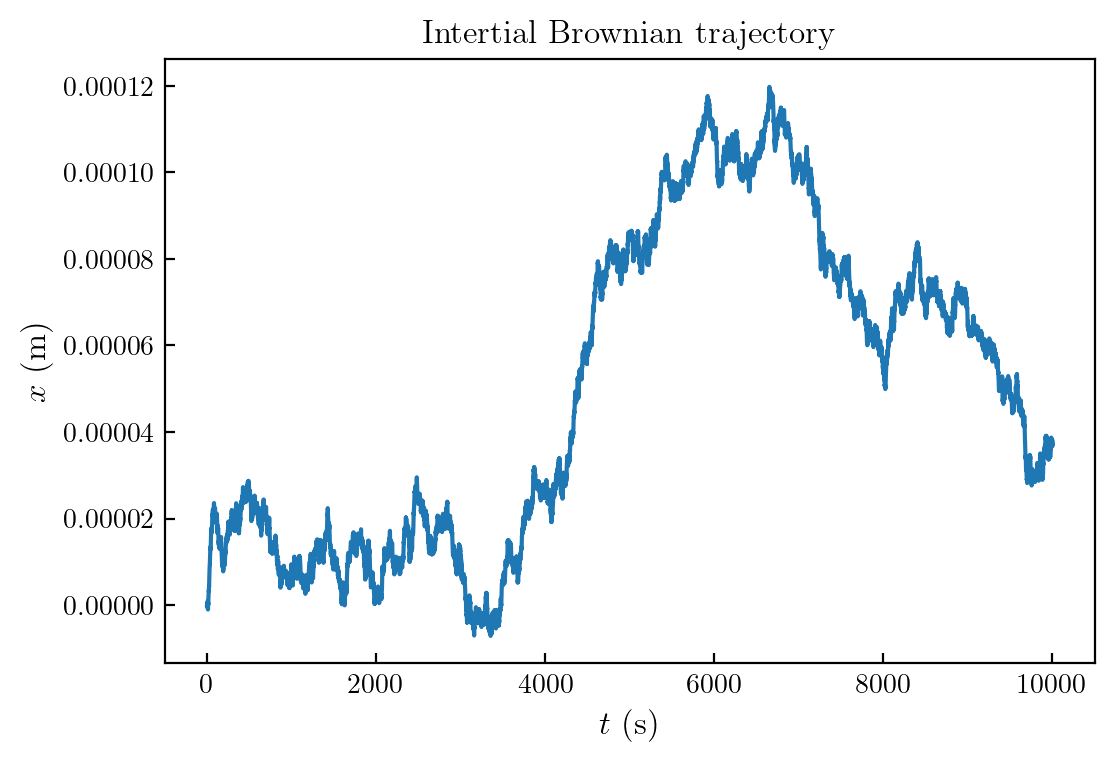

In [7]:
plt.plot(np.arange(len(x))*tau, x)
plt.title("Intertial Brownian trajectory")
plt.ylabel("$x$ (m)")
plt.xlabel("$t$ (s)")
plt.show()

## Cross checking 

We now check that the simulated trajectory gives us the correct MSD properties to ensure the simulation si done properly. The MSD given by:

\begin{equation}
\mathrm{MSD}(\Delta t) = \left. \langle \left( x(t) - x(t+\Delta t \right)^2 \rangle \right|_t ~,
\end{equation}

with $\Delta t$ a lag time. The MSD, can be computed using the function defined in the cell below. For a lag time $\Delta t \ll \tau_B$ we should have:

\begin{equation}
\mathrm{MSD}(\Delta t) = \frac{k_\mathrm{B}T}{m} \Delta t ^2 ~,
\end{equation}

and for $\Delta t \gg \tau_B$:

\begin{equation}
\mathrm{MSD}(\tau) = 2 D \Delta t~,
\end{equation}

with $D = k_\mathrm{B}T / (6 \pi \eta a)$.


In [8]:
t = np.array([*np.arange(3,10,1), *np.arange(10,100,10), *np.arange(100,1000,100), *np.arange(1000,8000,1000)])
def msd(x,Dt):
    """Function that return the MSD for a list of time index t for a trajectory x"""
    _msd = lambda x, t : np.mean((x[:-t] - x[t:])**2)
    return [_msd(x,i) for i in t]
MSD = msd(x,t)

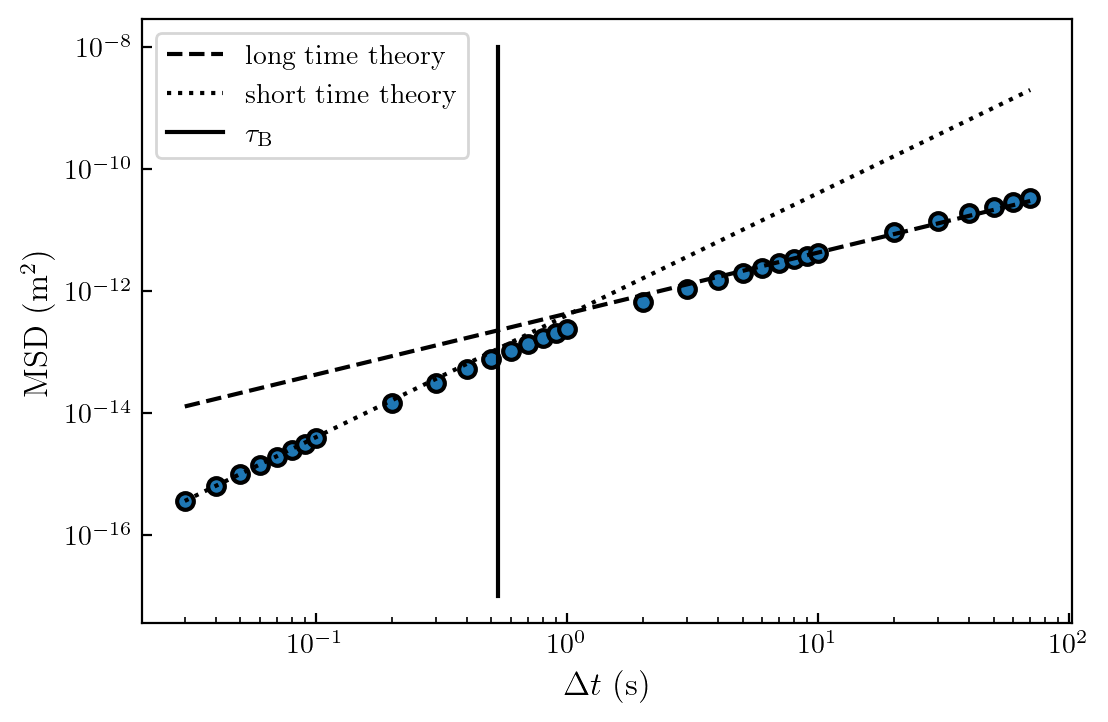

In [9]:
D = kbT/(6*np.pi*eta*a)
t_plot = t*tau
plt.loglog(t*tau,MSD, "o")
plt.plot(t*tau, (2*D*t_plot), "--", color = "k", label="long time theory")
plt.plot(t*tau, kbT/m * t_plot**2, ":", color = "k", label="short time theory")
plt.ylabel("MSD (m$^2$)")
plt.xlabel("$\Delta t$ (s)")
horiz_data = [1e-8, 1e-17]
t_horiz = [tauB, tauB]
plt.plot(t_horiz, horiz_data, "k", label="$\\tau_\mathrm{B}$")
plt.legend()
plt.show()

The simulations gives expected results. However, with the computer used, 6 seconds are needed to generate this trajectory. If someone wants to look at fine effects and need to generate millions of trajectories it is too long. In order to fasten the process, in the following  I use Cython to generate the trajectory using C language.

## Cython acceleration

In [10]:
# Loading Cython library
%load_ext Cython


We now write the same functions as in the first part of the appendix. However, we now indicate the type of each variable.

In [11]:
%%cython

import cython
cimport numpy as np
import numpy as np
from libc.math cimport sqrt
ctypedef np.float64_t dtype_t

cdef int N = 1000000 # length of the simulation

cdef dtype_t tau = 0.01 # simulation time step
cdef dtype_t m = 1e-8 # particle mass
cdef dtype_t a = 1e-6 # radius of the particle 
cdef dtype_t eta = 0.001 # viscosity (here water)
cdef dtype_t gamma = 6 * 3.14 * eta * a
cdef dtype_t kbT = 4e-21
cdef dtype_t tauB = m/gamma
cdef dtype_t[:] x = np.zeros(N)

@cython.boundscheck(False)
@cython.wraparound(False)
@cython.nonecheck(False)
@cython.cdivision(True) 
cdef dtype_t xi_cython( dtype_t xi1, dtype_t xi2, dtype_t wi):
    cdef dtype_t t = tau / tauB
    return (
        (2 + t) / (1 + t) * xi1
        - 1 / (1 + t) * xi2
        + sqrt(2 * kbT * gamma) / (m * (1 + t)) * tau * wi
    )

@cython.boundscheck(False)
@cython.wraparound(False)
@cython.nonecheck(False)
cdef dtype_t[:] _traj(dtype_t[:] x, dtype_t[:] wi):
    cdef int i
    for i in range(2, N):
        
        x[i] = xi_cython(x[i-1], x[i-2], wi[i])
    return x    


def trajectory_cython():
    

    cdef dtype_t[:] wi = np.random.normal(0, np.sqrt(tau), N).astype('float64')
    
    
    return _traj(x, wi)



In [12]:
%timeit trajectory(1000000)

6.79 s ± 92.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [13]:
%timeit trajectory_cython()

30.6 ms ± 495 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Again, we check that the results given through the use of Cython gives the correct MSD

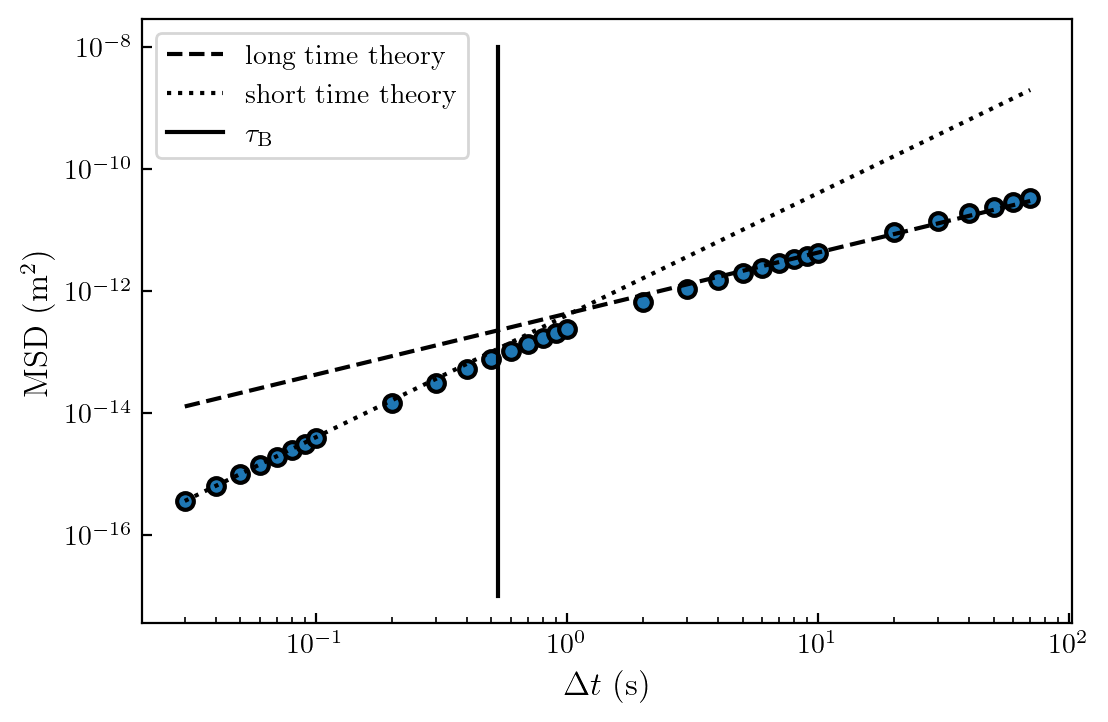

In [14]:
x=np.asarray(trajectory_cython())
D = kbT/(6*np.pi*eta*a)
t_plot = t*tau
plt.loglog(t*tau,MSD, "o")
plt.plot(t*tau, (2*D*t_plot), "--", color = "k", label="long time theory")
plt.plot(t*tau, kbT/m * t_plot**2, ":", color = "k", label="short time theory")

horiz_data = [1e-8, 1e-17]
t_horiz = [tauB, tauB]
plt.plot(t_horiz, horiz_data, "k", label="$\\tau_\mathrm{B}$")
plt.xlabel("$\\Delta t$ (s)")
plt.ylabel("MSD (m$^2$)")
plt.legend()
plt.show()

### Conclusion

Finally, one only needs $\simeq 30$ ms to generate the trajectory instead of $\simeq 7$ s which is a
$\simeq 250\times$ improvement speed. The simulation si here bound to the time needed to generate the array of random numbers which is still done using numpy function. After further checking, Numpy random generation si as optimize as one could do so there is no benefit on cythonizing the random generation. For the sake of completness one could fine a Cython version to generate random numbers. Found thanks to Senderle on [Stackoverflow](https://stackoverflow.com/questions/42767816/what-is-the-most-efficient-and-portable-way-to-generate-gaussian-random-numbers). Tacking into account that, the time improvment on the actual computation of the trajectory **without** the random number generation is done with an $\simeq 1100\times$ improvement speed.

In [15]:
%%cython
from libc.stdlib cimport rand, RAND_MAX
from libc.math cimport log, sqrt
import numpy as np
import cython

cdef double random_uniform():
    cdef double r = rand()
    return r / RAND_MAX

cdef double random_gaussian():
    cdef double x1, x2, w

    w = 2.0
    while (w >= 1.0):
        x1 = 2.0 * random_uniform() - 1.0
        x2 = 2.0 * random_uniform() - 1.0
        w = x1 * x1 + x2 * x2

    w = ((-2.0 * log(w)) / w) ** 0.5
    return x1 * w

@cython.boundscheck(False)
cdef void assign_random_gaussian_pair(double[:] out, int assign_ix):
    cdef double x1, x2, w

    w = 2.0
    while (w >= 1.0):
        x1 = 2.0 * random_uniform() - 1.0
        x2 = 2.0 * random_uniform() - 1.0
        w = x1 * x1 + x2 * x2

    w = sqrt((-2.0 * log(w)) / w)
    out[assign_ix] = x1 * w
    out[assign_ix + 1] = x2 * w

@cython.boundscheck(False)
def my_uniform(int n):
    cdef int i
    cdef double[:] result = np.zeros(n, dtype='f8', order='C')
    for i in range(n):
        result[i] = random_uniform()
    return result

@cython.boundscheck(False)
def my_gaussian(int n):
    cdef int i
    cdef double[:] result = np.zeros(n, dtype='f8', order='C')
    for i in range(n):
        result[i] = random_gaussian()
    return result

@cython.boundscheck(False)
def my_gaussian_fast(int n):
    cdef int i
    cdef double[:] result = np.zeros(n, dtype='f8', order='C')
    for i in range(n // 2):  # Int division ensures trailing index if n is odd.
        assign_random_gaussian_pair(result, i * 2)
    if n % 2 == 1:
        result[n - 1] = random_gaussian()

    return result



In [16]:
%timeit my_gaussian_fast(1000000)

30.9 ms ± 941 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [17]:
%timeit np.random.normal(0,1,1000000)

26.4 ms ± 1.87 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


One can thus see, that even a pure C implementation can be slower than the Numpy one, thanks to a great optimization.

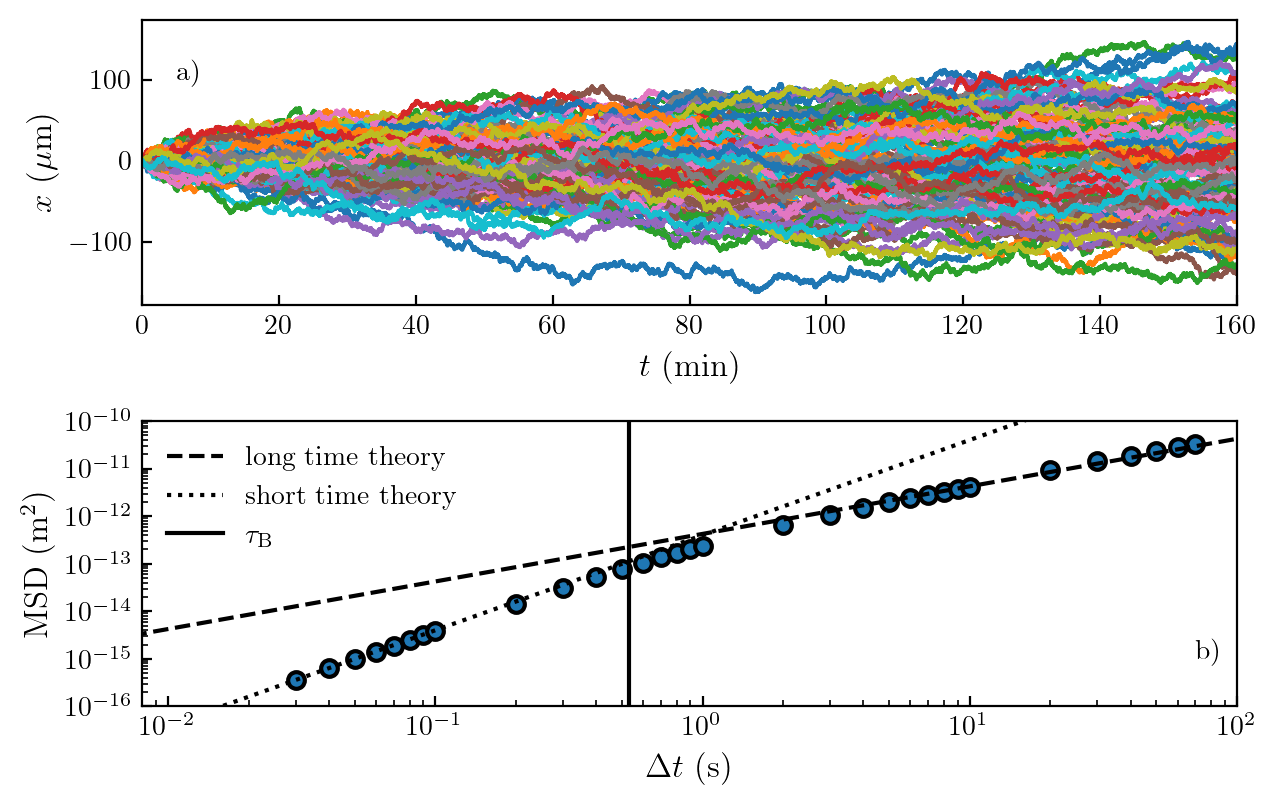

In [18]:
fig = plt.figure(figsize = (cm2inch(16), cm2inch(10)))
gs = fig.add_gridspec(2, 1)
f_ax1 = fig.add_subplot(gs[0, 0])
for i in range(100):
    x = np.asarray(trajectory_cython())* 1e6
    plt.plot(np.arange(N)*tau / 60, x)

plt.ylabel("$x$ ($\mathrm{\mu m}$)")
plt.xlabel("$t$ (min)")
plt.text(5,100, "a)")
plt.xlim([0,160])
f_ax1 = fig.add_subplot(gs[1, 0])
                 
x=np.asarray(trajectory_cython())
D = kbT/(6*np.pi*eta*a)
plt.loglog(t*tau,MSD, "o")
t_plot = np.linspace(0.5e-2,5e3,1000)
plt.plot(t_plot, (2*D*t_plot), "--", color = "k", label="long time theory")
plt.plot(t_plot, kbT/m * t_plot**2, ":", color = "k", label="short time theory")

horiz_data = [1e-7, 1e-18]
t_horiz = [tauB, tauB]
plt.plot(t_horiz, horiz_data, "k", label="$\\tau_\mathrm{B}$")
plt.ylabel("MSD (m$^2$)")
plt.xlabel("$\\Delta t$ (s)")
ax = plt.gca()
locmaj = mpl.ticker.LogLocator(base=10.0, subs=(1.0, ), numticks=100)
ax.yaxis.set_major_locator(locmaj)
locmin = mpl.ticker.LogLocator(base=10.0, subs=np.arange(2, 10) * .1,
                                      numticks=100)
ax.yaxis.set_minor_locator(locmin)
ax.yaxis.set_minor_formatter(mpl.ticker.NullFormatter())
plt.legend(frameon=False)
plt.text(0.7e2,1e-15, "b)")
plt.xlim([0.8e-2,1e2])
plt.ylim([1e-16,1e-10])
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

plt.savefig("intertial_langevin.pdf")
plt.show()